# Guided example and challenge

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

And that is your challenge.

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate might just be happier people.

### Notebook Flow

    * Import Libraries
    * Cleaning Data
    * Exploring Data
    * Feature Selection
    * Run LinearSVM 

## Importing Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import time
%matplotlib inline

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
raw_data = raw_data.copy()

In [5]:
raw_data.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dropping observations with missing values

In [6]:
raw_drop = raw_data.dropna(axis=0)

In [7]:
raw_drop['rating'].describe()

count    15864.000000
mean         3.760952
std          1.285518
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [8]:
raw_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15864 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 82.4+ MB


#### Note we've lost about 21% of our observations by dropping missing data at the row level, but we still have close to 16,000 observations

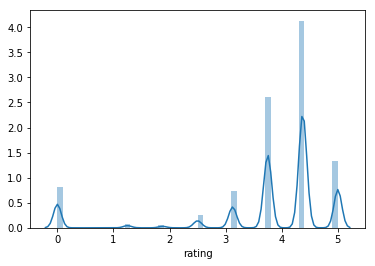

In [9]:
sns.distplot(raw_drop['rating'])

### Interesting, our target has more than 6 distinct values

In [10]:
raw_drop.rating.value_counts()

4.375    6552
3.750    4136
5.000    2106
0.000    1296
3.125    1165
2.500     405
1.250     123
1.875      81
Name: rating, dtype: int64

In [11]:
raw_drop = raw_drop.round({'rating' : 0})

In [12]:
raw_drop.rating.value_counts()

4.0    10688
5.0     2106
0.0     1296
3.0     1165
2.0      486
1.0      123
Name: rating, dtype: int64

Now we have 6 distinct catergories 

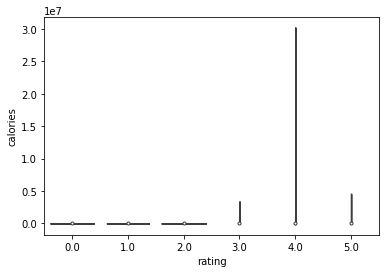

In [13]:
sns.violinplot(x='rating', y='calories', data=raw_drop)

Even though the y axis values are a bit distorted, there might be something to this relationship.

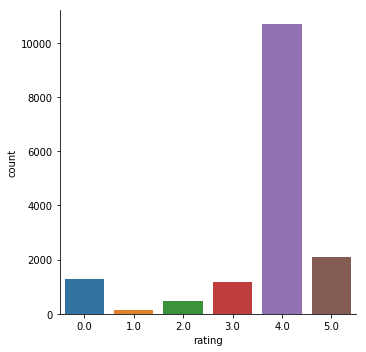

In [14]:
sns.catplot(x="rating", kind="count", data=raw_drop)

This clear class imbalence needs to be accounted for

## Feature Selection

I'll use a chi-squared test to reduce the number of features to select from. 

In [39]:
# selecting data and target
data = raw_drop.iloc[:, 2:]
target = raw_drop['rating']

# Select 15 features with highest chi-squared scores
chi2_selector = SelectKBest(chi2, k=15)
chi2_selector.fit_transform(data, target)

# Get columns to keep
cols = chi2_selector.get_support(indices=True)

X_kbest = pd.DataFrame(chi2_selector.fit_transform(data, target))

# Create new dataframe with only desired columns, or overwrite existing
X_kbest_feat = data.iloc[:,cols]

In [40]:
X_kbest_feat.head()

,calories,protein,fat,sodium,alcoholic,bake,bitters,cocktail,cocktail party,drink,gin,harpercollins,house & garden,sauté,spirit
0,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,403.0,18.0,23.0,1439.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,547.0,20.0,32.0,452.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_kbest_feat.columns[:]

Index(['calories', 'protein', 'fat', 'sodium', 'alcoholic', 'cocktail',
       'drink', 'gin', 'house & garden', 'spirit'],
      dtype='object')

Using a chi-squared test of fit, I have selected 30 features. 

In [3]:
def count_groups(df, x, y):
# Table of group counts  
    count_table = pd.crosstab(df[x], df[y])
# A plot of the counts of each group    
    ax = sns.countplot(y=y, 
                       hue=x,
                       data=df,
                       palette=sns.color_palette("husl", 2))
    plt.title('Comparison of Counts')
# Chi-Squared test on groups
    _, chi = stats.chisquare(count_table, axis=None)
    return count_table, print(chi)

In [2]:
count_groups(raw_drop, 'rating', 'alcoholic')

NameError: name 'raw_drop' is not defined

Interesting ratings associatied with alcoholic.

0.0


(bake     0.0   1.0
 rating            
 0.0     1171   125
 1.0       94    29
 2.0      363   123
 3.0      880   285
 4.0     7864  2824
 5.0     1767   339, None)

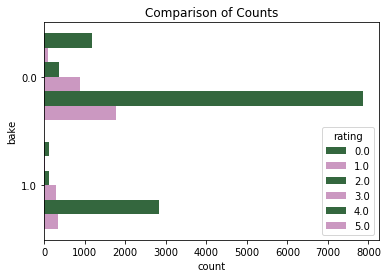

In [20]:
count_groups(raw_drop, 'rating', 'bake')

### Model Creation

In [41]:
# selecting the "data" and "target"
X = X_kbest_feat
y = target

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
# timer script
start_time = time.time()

# Create support vector classifier
svc = LinearSVC(class_weight='balanced', C=1.0, random_state=0, dual=False)

# Train classifier
model = svc.fit(X_train, y_train)

# making predictions 
y_pred = svc.predict(X_test)

# classification report
print('Classification Report : \n', classification_report(y_test, y_pred, digits = 4))

# confusion matrix
print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

# timer script
print("--- %s seconds ---" % (time.time() - start_time))

Classification Report : 
               precision    recall  f1-score   support

         0.0     0.4127    0.3047    0.3506       256
         1.0     0.0000    0.0000    0.0000        22
         2.0     0.0000    0.0000    0.0000        94
         3.0     0.0000    0.0000    0.0000       246
         4.0     0.6930    0.9782    0.8112      2109
         5.0     0.1429    0.0022    0.0044       446

   micro avg     0.6751    0.6751    0.6751      3173
   macro avg     0.2081    0.2142    0.1944      3173
weighted avg     0.5140    0.6751    0.5681      3173

Confusion Matrix : 
 [[  78    0    0    0  175    3]
 [   3    0    0    0   19    0]
 [   5    0    0    0   89    0]
 [  10    0    0    0  234    2]
 [  45    0    0    0 2063    1]
 [  48    0    0    0  397    1]]
--- 1.2775864601135254 seconds ---


C:\Users\latee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\latee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\latee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
# timer script
start_time = time.time()

scores = cross_val_score(svc, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# timer script
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\latee\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\latee\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\latee\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.68 (+/- 0.01)
--- 21.417386770248413 seconds ---


C:\Users\latee\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy w/300 features: 0.62 (+/- 0.05).

# Would Down Sampling Help?

We simply cannot get away with the class imbalence here. 

Let's try sampling down the 4 Star class.

In [24]:
# Separate majority and minority classes
raw_drop_rating0 = raw_drop[raw_drop.rating==0]
raw_drop_rating1 = raw_drop[raw_drop.rating==1]
raw_drop_rating2 = raw_drop[raw_drop.rating==2]
raw_drop_rating3 = raw_drop[raw_drop.rating==3]
df_majority = raw_drop[raw_drop.rating==4]
raw_drop_rating5 = raw_drop[raw_drop.rating==5]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # sample without replacement
                                   n_samples=1035,    # to match minority class
                                   random_state=123)  # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([raw_drop_rating0, raw_drop_rating1, raw_drop_rating2,
                            raw_drop_rating3, df_majority_downsampled, raw_drop_rating5])
 
# Display new class counts
df_downsampled.rating.value_counts()

5.0    2106
0.0    1296
3.0    1165
4.0    1035
2.0     486
1.0     123
Name: rating, dtype: int64

Now let's see if we can get more useful information about all classes by creating a modelfrom this data.

In [25]:
# timer script
start_time = time.time()

# selecting data and target
data['title'] = df_downsampled['title']
data = df_downsampled.iloc[:, 2:]
target = df_downsampled['rating']

# Select 30 features with highest chi-squared scores
chi2_selector = SelectKBest(chi2, k=7)
chi2_selector.fit_transform(data, target)

# Get columns to keep
cols = chi2_selector.get_support(indices=True)

X_kbest = pd.DataFrame(chi2_selector.fit_transform(data, target))

# Create new dataframe with only desired columns, or overwrite existing
X_kbest_feat1 = data.iloc[:,cols]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1575782299041748 seconds ---


In [26]:
print('Old Columns : ', X_kbest_feat.columns)

print('New Columns : ', X_kbest_feat1.columns)

Old Columns :  Index(['calories', 'protein', 'fat', 'sodium', 'alcoholic', 'cocktail',
       'drink', 'gin', 'house & garden', 'spirit'],
      dtype='object')
New Columns :  Index(['calories', 'protein', 'fat', 'sodium', 'alcoholic', 'drink',
       'house & garden'],
      dtype='object')


### Downsampled Model

In [27]:
### Model Creation

# selecting the "data" and "target"
X = X_kbest_feat1
y = target

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# timer script
start_time = time.time()

# Create support vector classifier
svc = LinearSVC(C=1.0, random_state=0, dual=False, class_weight='balanced')

# Train classifier
model = svc.fit(X_train, y_train)

# making predictions 
y_pred = svc.predict(X_test)

# classification report
print('Classification Report : \n', classification_report(y_test, y_pred, digits = 4))

# confusion matrix
print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

# timer script
print("--- %s seconds ---" % (time.time() - start_time))

Classification Report : 
               precision    recall  f1-score   support

         0.0     0.5573    0.2694    0.3632       271
         1.0     0.0000    0.0000    0.0000        23
         2.0     0.0000    0.0000    0.0000        90
         3.0     0.0833    0.0045    0.0086       221
         4.0     0.0000    0.0000    0.0000       207
         5.0     0.3503    0.8933    0.5033       431

   micro avg     0.3693    0.3693    0.3693      1243
   macro avg     0.1652    0.1945    0.1458      1243
weighted avg     0.2578    0.3693    0.2552      1243

Confusion Matrix : 
 [[ 73   0   0   5   0 193]
 [  1   0   0   0   0  22]
 [  7   0   0   0   0  83]
 [  6   0   0   1   0 214]
 [  5   0   0   0   0 202]
 [ 39   1   0   6   0 385]]
--- 0.10372185707092285 seconds ---


C:\Users\latee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\latee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\latee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
# timer script
start_time = time.time()

scores = cross_val_score(svc, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# timer script
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy: 0.36 (+/- 0.02)
--- 0.9834733009338379 seconds ---


Well that made things worse across the board. 